In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

In [15]:
dataset = pd.read_csv('train.csv')
X = dataset.copy()
y = X.pop('SalePrice')
test = pd.read_csv("test.csv")
X

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal


In [24]:
# Remove columns with many null values
include_var = []
missing_count = X.isnull().sum()
for variable in missing_count.keys():
    if missing_count[variable] < 700:
        include_var.append(variable)
X = X[include_var]
test = test[include_var]
_ = X.pop("Id")
Ident = test.pop("Id")


In [4]:
# Replace non-numerical values to numerical values(int type) 
# Using label encoding
# Replace null values with value 0
for column in X.select_dtypes("object"):
    X[column], _ = X[column].factorize()
X = X.replace(-1, 0)
X = X.fillna(0)

for column in test.select_dtypes("object"):
    test[column], _ = test[column].factorize()
test = test.replace(-1, 0)
test = test.fillna(0)

In [5]:
# Split the data into training data and testing data

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=0)
train_y

1292    107500
1018    160000
1213    145000
1430    192140
810     181000
         ...  
763     337000
835     128000
1216    112000
559     234000
684     221000
Name: SalePrice, Length: 1095, dtype: int64

In [6]:
# Create a neural network with 6 layers, 5 hidden layers with relu activation functions, taking 75 variable inputs

model = keras.Sequential([
    layers.Dense(units=25, activation="relu", input_shape=[75]),
    layers.Dense(units=25, activation="relu"),
    layers.Dense(units=1)
])

# Use adam optimizer that has adaptive learning rate to optimize neural network, lower loss function
model.compile(
    optimizer='adam',
    loss='mae',
    metrics=['accuracy']
)

# To detect overfitting, we implement EarlyStopping()
early_stopping = callbacks.EarlyStopping(
    min_delta=10, # minimum amount of change in the loss function to count as improvement
    patience=100, # the number of epochs to wait before stopping the process
    restore_best_weights=True # If false, computer will use the last value of weights, possibly not the best
)


# We start training the model with batch_size 256 and we iterate through the batches 10 times
history = model.fit(
    train_X, train_y, 
    validation_data=(val_X, val_y), 
    batch_size=32,
    epochs=1000,
    #callbacks=[early_stopping],
    verbose=0
)

Minimum validation loss:  22531.6796875


(12311.7109375, 40000.0)

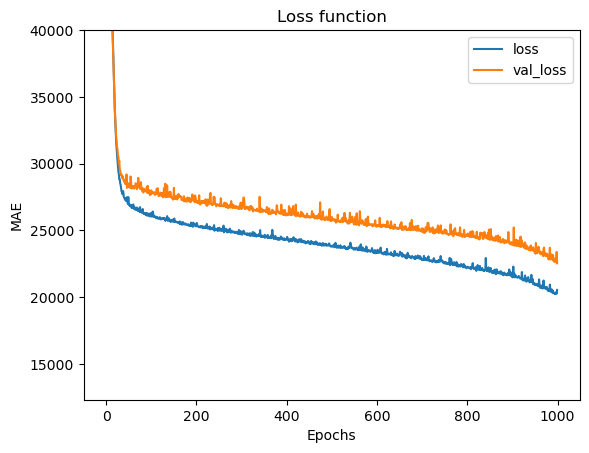

In [7]:
# Plot the results of the loss function
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
plt.title("Loss function")
plt.xlabel("Epochs")
plt.ylabel("MAE")
print("Minimum validation loss: ", history_df['val_loss'].min())
# plt.xlim(left=2000)
plt.ylim(top=40000)

In [8]:
# Predict the testing data for X and compare it to y
predictions = model.predict(test)
final = pd.DataFrame(Ident)
final['SalePrice'] = predictions
print(final)
test_predictions = final.to_csv("submission.csv", index=False)

46/46 [==============================] - 0s 2ms/step
        Id      SalePrice
0     1461  149094.140625
1     1462  180855.750000
2     1463  197461.265625
3     1464  185975.640625
4     1465  160955.765625
...    ...            ...
1454  2915   80462.609375
1455  2916  101142.976562
1456  2917  193258.000000
1457  2918  115154.156250
1458  2919  213571.109375

[1459 rows x 2 columns]


In [9]:
# Compare with random forests
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

rtree = RandomForestRegressor(random_state=1)
rtree.fit(train_X, train_y)

predictions = rtree.predict(val_X)
print(mean_absolute_error(predictions, val_y))

predictions = rtree.predict(test)
final = pd.DataFrame(Ident)
final['SalePrice'] = predictions
print(final)
test_predictions = final.to_csv("submission.csv", index=False)

17165.829068493153
        Id  SalePrice
0     1461  130488.50
1     1462  153117.13
2     1463  188398.15
3     1464  187137.32
4     1465  199826.12
...    ...        ...
1454  2915   86241.93
1455  2916   89132.12
1456  2917  153106.37
1457  2918  108344.68
1458  2919  234346.68

[1459 rows x 2 columns]
